In [18]:
!pip install spacy

In [19]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 11.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
!pip install gensim

In [41]:
import pandas as pd

base_path = '/files/Project/'

try:
    
    telegram_df = pd.read_csv(base_path + 'Telegram_sentiment.csv', delimiter=';', decimal=',')
    print("File imported successfully. Data preview:")
    print(telegram_df.head())  # Display the first few rows to check that everything is correct.

except pd.errors.ParserError as e:
    print("A parsing error occurred:", e)
except FileNotFoundError as e:
    print("File not found:", e)
except Exception as e:
    print("An unexpected error occurred:", e)


File imported successfully. Data preview:
   Column1         channel    id  \
0        0  binancesignals  1382   
1        1  binancesignals  1381   
2        2  binancesignals  1380   
3        3  binancesignals  1379   
4        4  binancesignals  1378   

                                                text              date  views  \
0           bitcoin market cap surpasses 13 trillion  04/03/2024 16:33   6319   
1  update atausdt long leverage cross x10 smashed...  04/03/2024 11:48   6847   
2  altcoins started make move bitcoin total marke...  03/03/2024 19:53   8066   
3  coin maticusdt timeframe 1d observation broken...  03/03/2024 17:52   7740   
4  coin aptusdt timeframe 1d observation broken m...  03/03/2024 17:50   7668   

                                              scores  compound sentiment_type  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000        NEUTRAL  
1  {'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'comp...    0.5106       POSITIVE  
2  {'neg': 0.0

In [44]:
import spacy
from spacy.lang.en import English

# Load the Spacy model
nlp = spacy.load('en_core_web_sm')

# Function to tokenize and clean the data
def tokenize(text):
    # Convert the input to string if it's not already text
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return tokens

# Check if the DataFrame has the 'text' column
if 'text' in telegram_df.columns:
    # Apply tokenization to the text column
    telegram_df['tokens'] = telegram_df['text'].apply(tokenize)
else:
    print("The 'text' column does not exist in the DataFrame.")


In [45]:
from gensim.corpora import Dictionary

# Create a dictionary of all tokens
dct = Dictionary(telegram_df['tokens'])

# Filter out tokens that are too rare or too frequent
dct.filter_extremes(no_below=5, no_above=0.5)

# Create the BoW corpus
corpus = [dct.doc2bow(text) for text in telegram_df['tokens']]


In [46]:
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dct, 
    num_topics=10, 
    random_state=100, 
    update_every=1, 
    chunksize=100, 
    passes=10, 
    alpha='auto', 
    per_word_topics=True
)


In [47]:
# Example of keywords associated with cryptocurrencies
keywords_per_coin = {
    'Bitcoin': ['bitcoin', 'btc', 'BTC', 'Bitcoin', 'coin', 'BITCOIN'],
    'Ethereum': ['ethereum', 'ETH', 'Ethereum', 'eth', 'Altcoin', 'Altcoins', 'altcoins', 'altcoin'],
}

# Initialize the concept matrix
concept_matrix = pd.DataFrame(0, index=range(lda_model.num_topics), columns=keywords_per_coin.keys())

# Fill the concept matrix
for topic_id in range(lda_model.num_topics):
    topic_keywords = lda_model.show_topic(topic_id)
    for word, weight in topic_keywords:
        for coin, keywords in keywords_per_coin.items():
            if word in keywords:
                concept_matrix.loc[topic_id, coin] += weight

# Display the concept matrix to verify
print(concept_matrix)


    Bitcoin  Ethereum
0  0.000000  0.070693
1  0.000000  0.000000
2  0.048641  0.000000
3  0.030579  0.000000
4  0.000000  0.000000
5  0.100396  0.000000
6  0.000000  0.000000
7  0.000000  0.000000
8  0.000000  0.000000
9  0.000000  0.000000


In [48]:
# Step 1: Create the topic distribution for each document
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Convert the topic distributions into a DataFrame, with one document per row and topics as columns
doc_topics_df = pd.DataFrame([{topic: prob for topic, prob in dist} for dist in doc_topic_distributions])

# Fill missing values with 0, as not all topics appear in each document
doc_topics_df = doc_topics_df.fillna(0)

doc_concepts = doc_topics_df.dot(concept_matrix)

# Step 2: Integrate sentiment scores into the 'doc_concepts' DataFrame
doc_concepts['sentiment_type'] = telegram_df['sentiment_type']
doc_concepts['compound'] = telegram_df['compound']

# Check the first few rows to ensure everything worked correctly
print(doc_concepts.head())


    Bitcoin  Ethereum sentiment_type  compound
0  0.013357  0.008414        NEUTRAL    0.0000
1  0.007631  0.001754       POSITIVE    0.5106
2  0.029140  0.006421        NEUTRAL    0.0000
3  0.011454  0.001513       NEGATIVE   -0.4767
4  0.016787  0.001576       NEGATIVE   -0.4767


                 Bitcoin  Ethereum
sentiment_type                    
NEGATIVE        0.016157  0.006189
NEUTRAL         0.016328  0.008733
POSITIVE        0.017566  0.007881


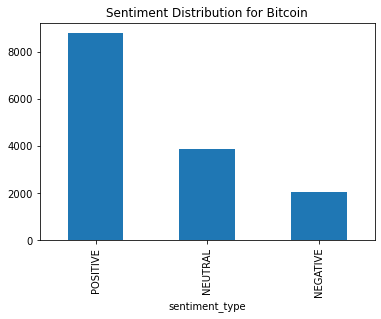

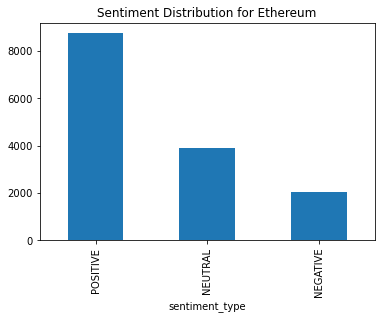

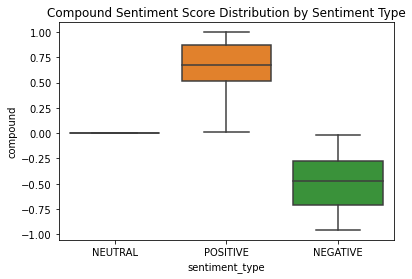

           Bitcoin  Ethereum  compound
Bitcoin   1.000000  0.066170  0.110994
Ethereum  0.066170  1.000000 -0.003636
compound  0.110994 -0.003636  1.000000


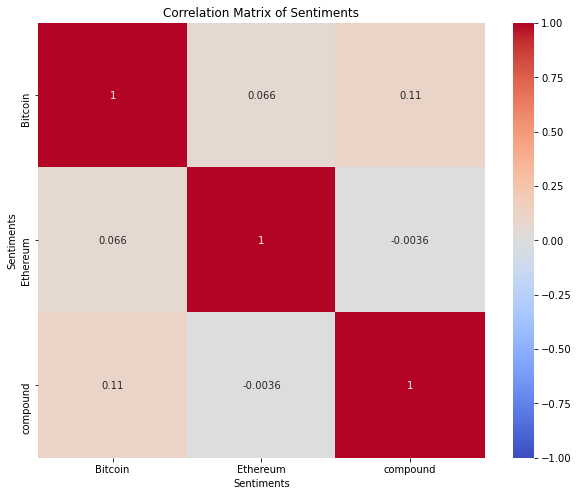

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate sentiment analysis by concept
mean_sentiments_by_concept = doc_concepts.groupby('sentiment_type').mean()[['Bitcoin', 'Ethereum']]
print(mean_sentiments_by_concept)

# Distribution of sentiment types for Bitcoin
bitcoin_sentiment_distribution = doc_concepts['sentiment_type'][doc_concepts['Bitcoin'] > 0].value_counts()
ethereum_sentiment_distribution = doc_concepts['sentiment_type'][doc_concepts['Ethereum'] > 0].value_counts()

# Visualization of the sentiment type distribution for Bitcoin
bitcoin_sentiment_distribution.plot(kind='bar', title='Sentiment Distribution for Bitcoin')
plt.show()

# Same for Ethereum
ethereum_sentiment_distribution.plot(kind='bar', title='Sentiment Distribution for Ethereum')
plt.show()

# Boxplot to visualize the distribution of compound scores by sentiment type
sns.boxplot(x='sentiment_type', y='compound', data=doc_concepts)
plt.title('Compound Sentiment Score Distribution by Sentiment Type')
plt.show()

# Calculate the correlation between compound scores and the presence of concepts
correlation_matrix = doc_concepts[['Bitcoin', 'Ethereum', 'compound']].corr()
print(correlation_matrix)

# Visualization of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Sentiments')
plt.show()


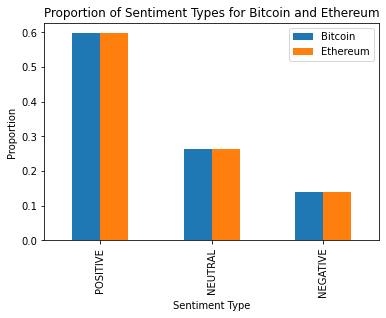

In [52]:
# Calculate the number of positive, neutral, and negative mentions for Bitcoin and Ethereum
bitcoin_sentiments = doc_concepts[doc_concepts['Bitcoin'] > 0]['sentiment_type'].value_counts()
ethereum_sentiments = doc_concepts[doc_concepts['Ethereum'] > 0]['sentiment_type'].value_counts()

# Create a DataFrame to compare the results
sentiment_comparison = pd.DataFrame({
    'Bitcoin': bitcoin_sentiments,
    'Ethereum': ethereum_sentiments
})

# Normalize the counts by the total mentions for each cryptocurrency
# to obtain proportions instead of absolute numbers
sentiment_comparison = sentiment_comparison.div(sentiment_comparison.sum(axis=0), axis=1)

# Visualization of the comparison
sentiment_comparison.plot(kind='bar', title='Proportion of Sentiment Types for Bitcoin and Ethereum')
plt.xlabel('Sentiment Type')
plt.ylabel('Proportion')
plt.show()


In [55]:
keywords_per_concept = {
    'Blockchain': ['blockchain', 'smart contract', 'consensus', 'hash rate'],
    'Security': ['security', 'hack', 'encryption', 'wallet'],
    'Regulations': ['regulation', 'SEC', 'law', 'compliance'],
    'Trading': ['trading', 'investment', 'market', 'bull', 'bear'],
    'Adoption': ['adoption', 'transaction', 'payment', 'retail'],
    'Innovation': ['update', 'upgrade', 'innovation', 'development']
}

# Initialize the concept matrix
concept_matrix = pd.DataFrame(0, index=range(lda_model.num_topics), columns=keywords_per_concept.keys())

# Fill the concept matrix
for topic_id in range(lda_model.num_topics):
    topic_keywords = lda_model.show_topic(topic_id)
    for word, weight in topic_keywords:
        for concept, keywords in keywords_per_concept.items():
            if word in keywords:
                concept_matrix.loc[topic_id, concept] += weight


In [56]:
# Create the DataFrame for topic distributions by document
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topics_df = pd.DataFrame([{topic: prob for topic, prob in dist} for dist in doc_topic_distributions]).fillna(0)

# Use the concept matrix to transform topic distributions into concept distributions
doc_concepts = doc_topics_df.dot(concept_matrix)

# Display the first few rows to check the concept distribution
print(doc_concepts.head())


   Blockchain  Security  Regulations   Trading  Adoption  Innovation
0         0.0       0.0          0.0  0.016176       0.0    0.007679
1         0.0       0.0          0.0  0.003372       0.0    0.004286
2         0.0       0.0          0.0  0.012343       0.0    0.021005
3         0.0       0.0          0.0  0.002908       0.0    0.004968
4         0.0       0.0          0.0  0.003030       0.0    0.003323


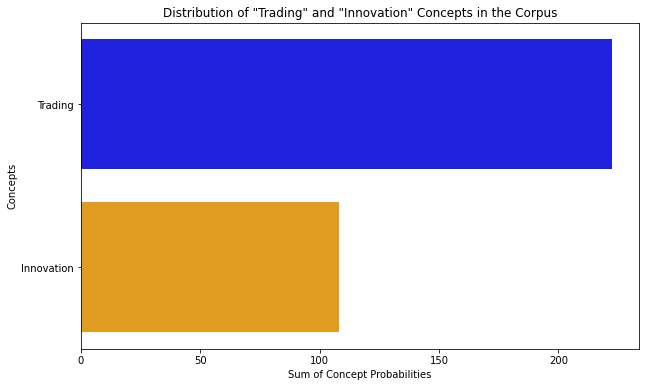

In [58]:
# Filter to keep only the "Trading" and "Innovation" concepts
filtered_doc_concepts = doc_concepts[['Trading', 'Innovation']]

# Sum the contributions of each concept across all documents
concept_sums = filtered_doc_concepts.sum().sort_values(ascending=False)

# Create a custom palette for the bar plot
palette = ['blue', 'orange']

# Bar plot of the sums of the concepts
plt.figure(figsize=(10, 6))
sns.barplot(x=concept_sums.values, y=concept_sums.index, palette=palette)
plt.title('Distribution of "Trading" and "Innovation" Concepts in the Corpus')
plt.xlabel('Sum of Concept Probabilities')
plt.ylabel('Concepts')
plt.show()


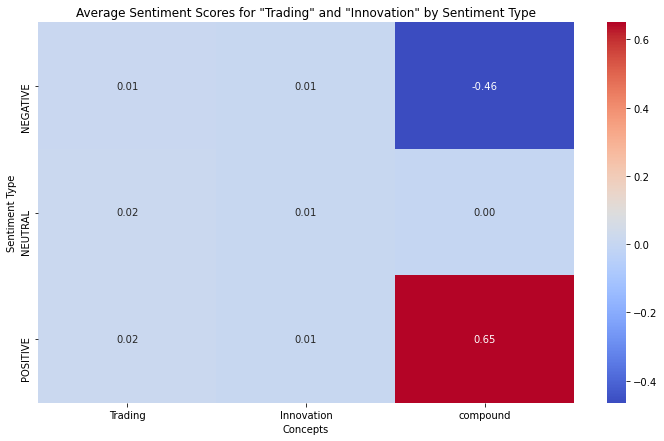

In [59]:
# Add sentiment columns to the `doc_concepts` DataFrame
doc_concepts['sentiment_type'] = telegram_df['sentiment_type']
doc_concepts['compound'] = telegram_df['compound']

# Filter to keep only the "Trading" and "Innovation" concepts along with sentiment columns
filtered_doc_concepts = doc_concepts[['Trading', 'Innovation', 'sentiment_type', 'compound']]

# Calculate the average sentiment scores for each concept by sentiment type
mean_sentiments_by_concept = filtered_doc_concepts.groupby('sentiment_type').mean()

# Visualization
plt.figure(figsize=(12, 7))
sns.heatmap(mean_sentiments_by_concept, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Sentiment Scores for "Trading" and "Innovation" by Sentiment Type')
plt.ylabel('Sentiment Type')
plt.xlabel('Concepts')
plt.show()
